---

Reconecte ao Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
DRIVE_DIRECTORY = "curso_ml"
DRIVE_DIRECTORY = os.path.join("/content/drive/MyDrive", DRIVE_DIRECTORY)

---

In [4]:
!pip install ucimlrepo

In [5]:
import os
import pickle
import plotly.express as px

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from ucimlrepo import fetch_ucirepo
from yellowbrick.regressor import ResidualsPlot

## Base de dados telemonitoramento de Parkinson

### Download e preparação dos dados

Assim como nos exercícios de classificação, aqui você também vai utilizar um dataset real. Vamos fazer o download e preparo desses dados, desta vez utilizando a biblioteca `ucimlrepo`.

Documentação do dataset: https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring

> Este conjunto de dados é composto por uma variedade de medições biomédicas de voz de 42 pessoas com Parkinson em estágio inicial, recrutadas para um ensaio clínico de seis meses de um dispositivo de telemonitoramento para monitoramento remoto da progressão dos sintomas. As gravações foram capturadas automaticamente nas casas dos pacientes. As colunas da tabela contêm número do sujeito, idade do sujeito, gênero do sujeito, intervalo de tempo desde a data de recrutamento inicial, UPDRS motor, UPDRS total e 16 medidas biomédicas de voz. Cada linha corresponde a uma das 5.875 gravações de voz desses indivíduos. O principal objetivo dos dados é prever as pontuações do UPDRS motor e total ('motor_UPDRS' e 'total_UPDRS') a partir das 16 medidas de voz.

In [6]:
# Seguindo as instruções da própria página do dataset:

# fetch dataset
parkinsons_telemonitoring = fetch_ucirepo(id=189)

# data (as pandas dataframes)
X = parkinsons_telemonitoring.data.features
y = parkinsons_telemonitoring.data.targets

Este dataset vem separado em variáveis preditoras `X` e variáveis alvo `y`.

In [7]:
X

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex
0,72,5.6431,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,0
1,72,12.6660,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,0
2,72,19.6810,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,0
3,72,25.6470,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,0
4,72,33.6420,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,61,142.7900,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367,0
5871,61,149.8400,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621,0
5872,61,156.8200,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157,0
5873,61,163.7300,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204,0


São 19 variáveis preditoras.

Perceba que `sex` está codificado de forma numérica, então vamos transformar em uma string para representar o dataset na forma mais natural possível. O mapeamento `int` -> `str` foi obtido na documentação do dataset (ver *Additional Variable Information*).

In [8]:
X.loc[:, "sex"] = X["sex"].map({0: "male", 1: "female"})

<ipython-input-8-2cb2c76c3724>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['male' 'male' 'male' ... 'male' 'male' 'male']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, "sex"] = X["sex"].map({0: "male", 1: "female"})


In [9]:
y

,motor_UPDRS,total_UPDRS
0,28.199,34.398
1,28.447,34.894
2,28.695,35.389
3,28.905,35.810
4,29.187,36.375
...,...,...
5870,22.485,33.485
5871,21.988,32.988
5872,21.495,32.495
5873,21.007,32.007


E neste caso são 2 variáveis alvo.

Agora vamos juntar as variáveis preditoras e alvo e um único dataframe. Como vamos utilizar somente uma variável alvo, estamos selecionando `total_UPDRS` para fazer parte de nosso dataset total.

In [10]:
data = pd.concat([X, y["total_UPDRS"]], axis=1)
data

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,total_UPDRS
0,72,5.6431,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,male,34.398
1,72,12.6660,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,male,34.894
2,72,19.6810,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,male,35.389
3,72,25.6470,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,male,35.810
4,72,33.6420,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,male,36.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,61,142.7900,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367,male,33.485
5871,61,149.8400,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621,male,32.988
5872,61,156.8200,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157,male,32.495
5873,61,163.7300,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204,male,32.007


Finalmente, vamos salvar os dados em um arquivo, para você utilizar como base no exercício.

In [11]:
data.to_csv(os.path.join(DRIVE_DIRECTORY, 'parkinson.csv'), index=False)

## Exploração dos dados

Recarregue os dados a partir da pasta do Drive.

In [12]:
base = pd.read_csv(os.path.join(DRIVE_DIRECTORY, 'parkinson.csv'))
base

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,total_UPDRS
0,72,5.6431,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,male,34.398
1,72,12.6660,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,male,34.894
2,72,19.6810,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,male,35.389
3,72,25.6470,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,male,35.810
4,72,33.6420,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,male,36.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,61,142.7900,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367,male,33.485
5871,61,149.8400,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621,male,32.988
5872,61,156.8200,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157,male,32.495
5873,61,163.7300,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204,male,32.007


Utilize o método adequado no DataFrame para exibir algumas estatísticas básicas.

In [13]:
base.describe()

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,total_UPDRS
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,64.804936,92.863722,0.006154,0.000044,0.002987,0.003277,0.008962,0.034035,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589,29.018942
std,8.821524,53.445602,0.005624,0.000036,0.003124,0.003732,0.009371,0.025835,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498,10.700283
min,36.000000,-4.262500,0.000830,0.000002,0.000330,0.000430,0.000980,0.003060,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983,7.000000
25%,58.000000,46.847500,0.003580,0.000022,0.001580,0.001820,0.004730,0.019120,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340,21.371000
50%,65.000000,91.523000,0.004900,0.000034,0.002250,0.002490,0.006750,0.027510,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500,27.576000
75%,72.000000,138.445000,0.006800,0.000053,0.003290,0.003460,0.009870,0.039750,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490,36.399000
max,85.000000,215.490000,0.099990,0.000446,0.057540,0.069560,0.172630,0.268630,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730,54.992000


Verifique se esta base de dados possui valores faltantes.

In [14]:
base.isnull().sum()

,0
age,0
test_time,0
Jitter(%),0
Jitter(Abs),0
Jitter:RAP,0
Jitter:PPQ5,0
Jitter:DDP,0
Shimmer,0
Shimmer(dB),0
Shimmer:APQ3,0


Exiba a correção entre os dados numéricos.

In [15]:
base.corr(numeric_only=True)

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,total_UPDRS
age,1.000000,0.019884,0.023071,0.035685,0.010255,0.013199,0.010258,0.101554,0.111130,0.098912,0.089983,0.135238,0.098913,0.007093,-0.104842,0.090208,-0.092870,0.120790,0.310290
test_time,0.019884,1.000000,-0.022837,-0.011349,-0.028888,-0.023290,-0.028876,-0.033870,-0.030962,-0.029020,-0.036504,-0.039110,-0.029017,-0.026357,0.036545,-0.038887,0.019261,-0.000563,0.075263
Jitter(%),0.023071,-0.022837,1.000000,0.865574,0.984181,0.968214,0.984184,0.709791,0.716704,0.664149,0.694002,0.645965,0.664147,0.825294,-0.675188,0.427128,0.226550,0.721849,0.074247
Jitter(Abs),0.035685,-0.011349,0.865574,1.000000,0.844622,0.790534,0.844626,0.649041,0.655866,0.623825,0.621397,0.589992,0.623823,0.699954,-0.706420,0.547097,0.352264,0.787848,0.066926
Jitter:RAP,0.010255,-0.028888,0.984181,0.844622,1.000000,0.947196,1.000000,0.681729,0.685551,0.650226,0.659831,0.603082,0.650225,0.792373,-0.641473,0.382891,0.214881,0.670652,0.064015
Jitter:PPQ5,0.013199,-0.023290,0.968214,0.790534,0.947196,1.000000,0.947203,0.732747,0.734591,0.676711,0.734021,0.668413,0.676710,0.864864,-0.662409,0.381503,0.175359,0.663491,0.063352
Jitter:DDP,0.010258,-0.028876,0.984184,0.844626,1.000000,0.947203,1.000000,0.681734,0.685556,0.650228,0.659833,0.603090,0.650227,0.792377,-0.641482,0.382886,0.214893,0.670660,0.064027
Shimmer,0.101554,-0.033870,0.709791,0.649041,0.681729,0.732747,0.681734,1.000000,0.992334,0.979828,0.984904,0.935457,0.979827,0.795158,-0.801416,0.468235,0.132540,0.615709,0.092141
Shimmer(dB),0.111130,-0.030962,0.716704,0.655866,0.685551,0.734591,0.685556,0.992334,1.000000,0.968015,0.976373,0.936338,0.968014,0.798077,-0.802496,0.472409,0.126111,0.635163,0.098790
Shimmer:APQ3,0.098912,-0.029020,0.664149,0.623825,0.650226,0.676711,0.650228,0.979828,0.968015,1.000000,0.962723,0.885695,1.000000,0.732736,-0.780697,0.436878,0.130735,0.576704,0.079363


Plote a correlação como um heatmap.

<Axes: >

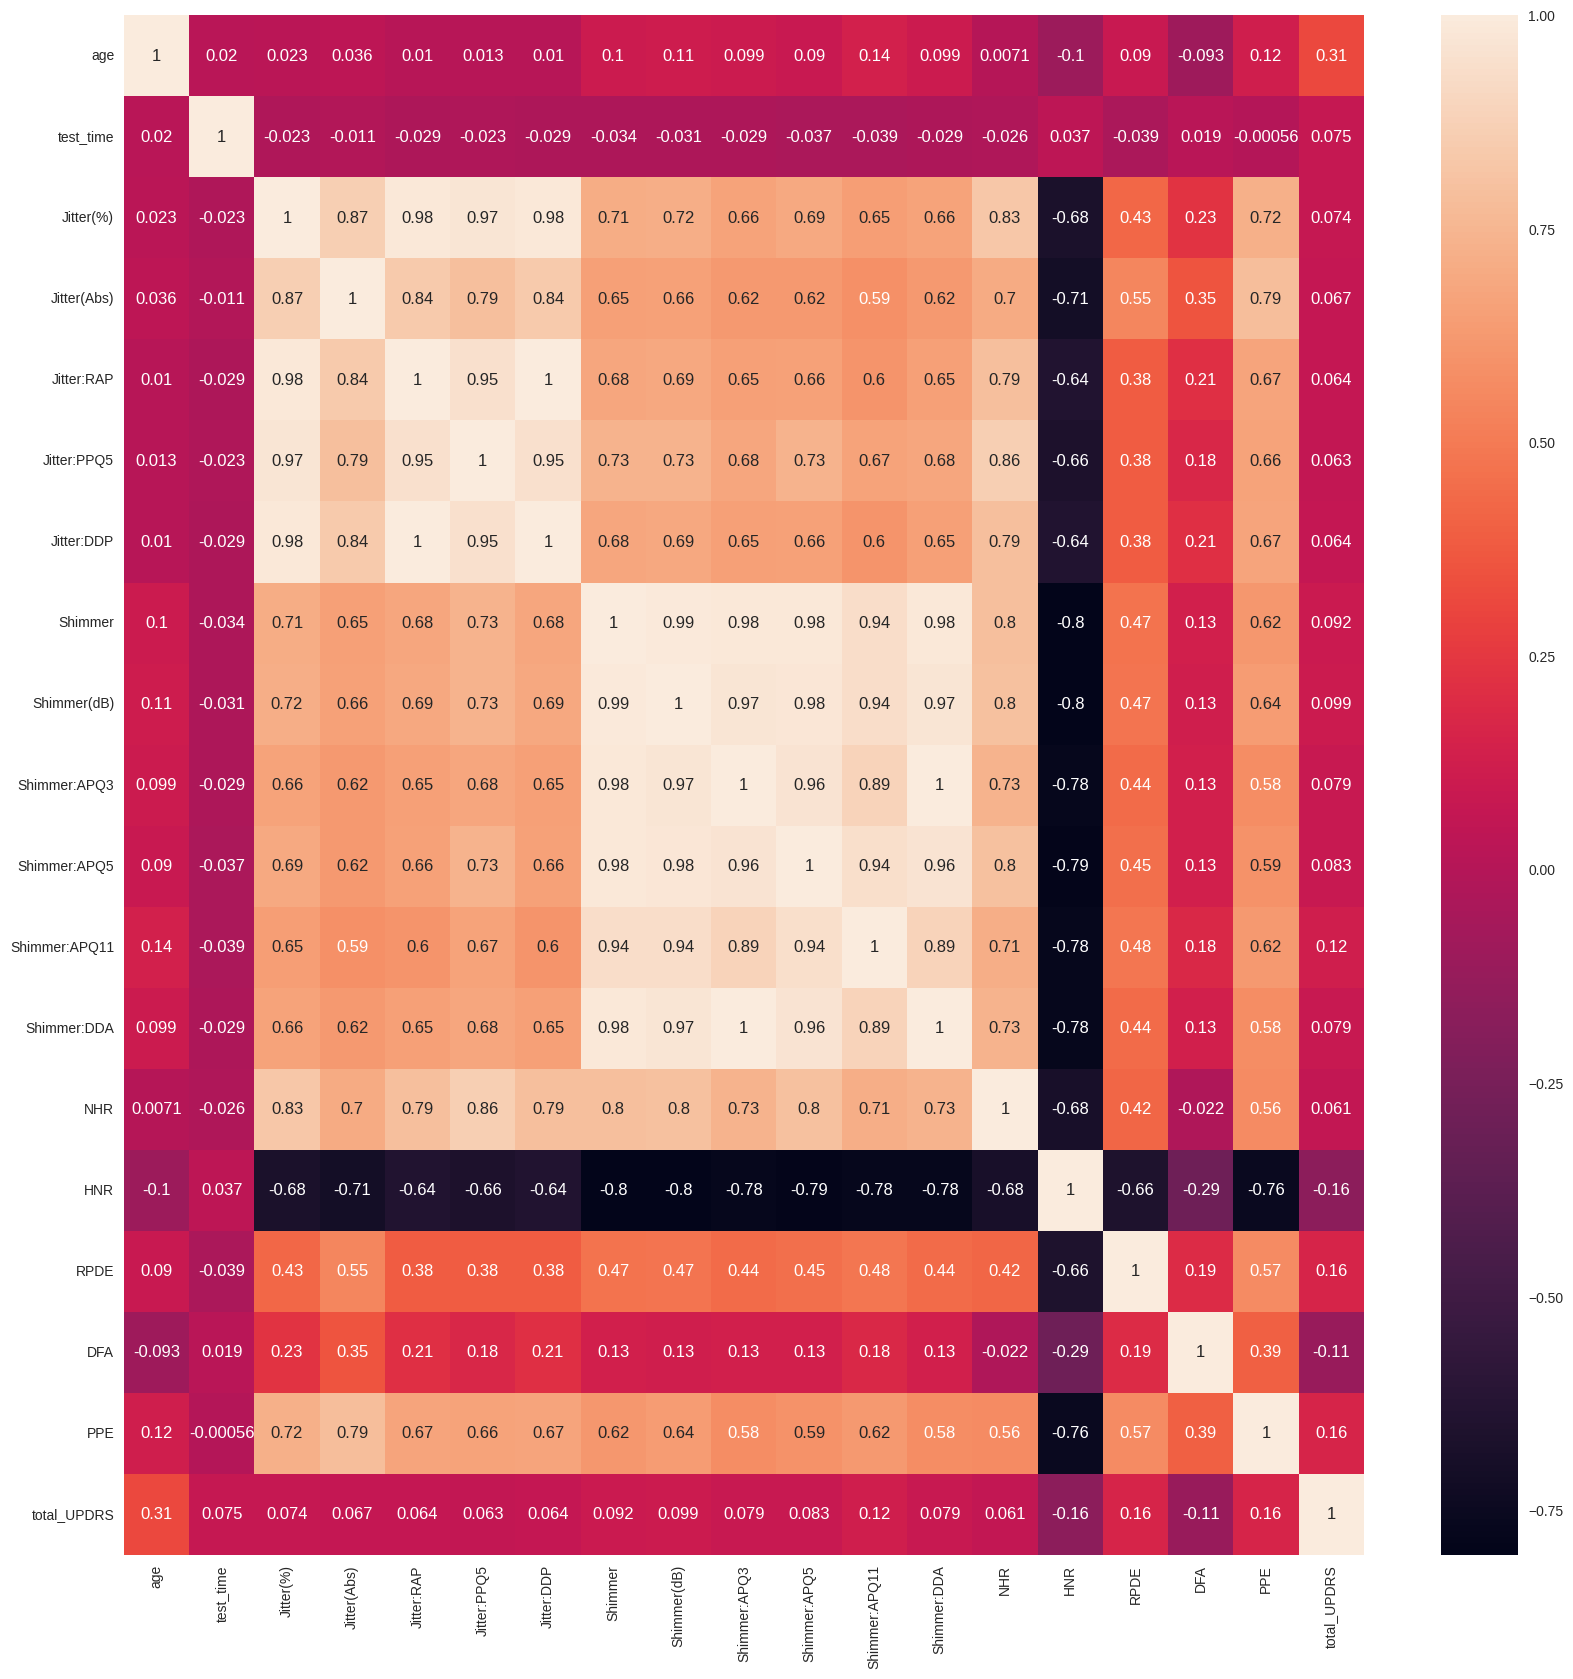

In [16]:
fig = plt.figure(figsize=(20, 20))
sns.heatmap(base.corr(numeric_only=True), annot=True)

## Tratamento da variável categórica

A única variável categórica é `sex`. Por padrão, nós poderíamos utilizar One Hot Encoding para tratar ela, mas como nesta base ela só exibe dois valores possíveis, nós podemos codificar esta coluna para mostrar `0` se o valor for `male`, ou `1` se for `female`, já que a segunda coluna é redundante. Isto é possível com um simples dicionário.

(Na prática, estamos desfazendo a operação que fizemos na preparação dos dados.)

In [17]:
base["sex"] = base["sex"].map({"male": 0, "female": 1})

## Divisão entre previsores e classe

Separe os atributos preditores do atributo alvo (que está na última coluna). Garanta que os valores estejam no formato de NumPy array.

In [18]:
X = base.iloc[:, :-1].values
X

array([[7.2000e+01, 5.6431e+00, 6.6200e-03, ..., 5.4842e-01, 1.6006e-01,
        0.0000e+00],
       [7.2000e+01, 1.2666e+01, 3.0000e-03, ..., 5.6477e-01, 1.0810e-01,
        0.0000e+00],
       [7.2000e+01, 1.9681e+01, 4.8100e-03, ..., 5.4405e-01, 2.1014e-01,
        0.0000e+00],
       ...,
       [6.1000e+01, 1.5682e+02, 3.4900e-03, ..., 5.7888e-01, 1.4157e-01,
        0.0000e+00],
       [6.1000e+01, 1.6373e+02, 2.8100e-03, ..., 5.6327e-01, 1.4204e-01,
        0.0000e+00],
       [6.1000e+01, 1.7073e+02, 2.8200e-03, ..., 5.7077e-01, 1.5336e-01,
        0.0000e+00]])

In [19]:
y = base.iloc[:, -1].values
y

array([34.398, 34.894, 35.389, ..., 32.495, 32.007, 31.513])

## Divisão em split de treinamento e teste

Separe os dados em um split de treinamento e um de teste (com 25% do total). Use `random_state=0` para garantir a reprodutibilidade da separação.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Confirme com o atributo `shape` a quantidade de instâncias e atributos de `X` e `y` nos dois splits.

In [21]:
X_train.shape, y_train.shape

((4406, 19), (4406,))

In [22]:
X_test.shape, y_test.shape

((1469, 19), (1469,))

## Salvar as variáveis

Salve estas variáveis em um arquivo `parkinson.pkl` na pasta do Drive.

In [23]:
with open(os.path.join(DRIVE_DIRECTORY, "parkinson.pkl"), "wb") as f:
    pickle.dump((X_train, y_train, X_test, y_test), f)

## Regressão linear

Neste exercício você vai fazer uma regressão linear múltiplia, já que a regressão linear simples é somente um caso especial da primeira.

Instancie um regressor linear e utilize os dados de treinamento para treiná-lo.

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

Exiba os coeficientes e o intercepto do regressor.

In [25]:
lr.coef_

array([ 3.06764438e-01,  1.96223919e-02,  5.19455543e+01, -6.28174323e+04,
       -8.13959659e+04, -4.01666638e+02,  2.74385181e+04,  1.36408292e+02,
       -5.06987050e+00, -1.06292645e+04, -5.85677564e+01,  5.53659894e+01,
        3.45830963e+03, -1.94494283e+01, -6.27280152e-01,  4.94120177e+00,
       -3.30541564e+01,  1.71973639e+01, -2.84638697e+00])

In [26]:
lr.intercept_

np.float64(39.54685627694328)

Calcule o score deste regressor com os dados de treinamento.

In [27]:
lr.score(X_train, y_train)

0.18400998454579887

Agora repita com os dados de teste.

In [28]:
lr.score(X_test, y_test)

0.14959086044761472

Isso indica que este algoritmo teve um desempenho muito ruim!

Agora utilize o modelo para predizer os dados de treinamento.

In [29]:
y_pred = lr.predict(X_train)
y_pred

array([24.8873548 , 25.05133343, 31.25683924, ..., 33.59312221,
       27.44455514, 29.67331537])

Como este é um problema de regressão linear múltipla, nós não conseguimos visualizar os dados plotando as variáveis preditoras no eixo x de um gráfico. Portanto, vamos utilizar a função `plt.plot`, que plota somente os valores `y`, na sequência em que aparecem no array. Assim podemos comparar as predições com os valores reais: se o algoritmo tivesse um bom desempenho, as duas linhas estariam sobrepostas.

Para reduzir o excesso de informação no gráfico, vamos exibir os valores de `y_train` e `y_pred` somente a cada 10 valores.

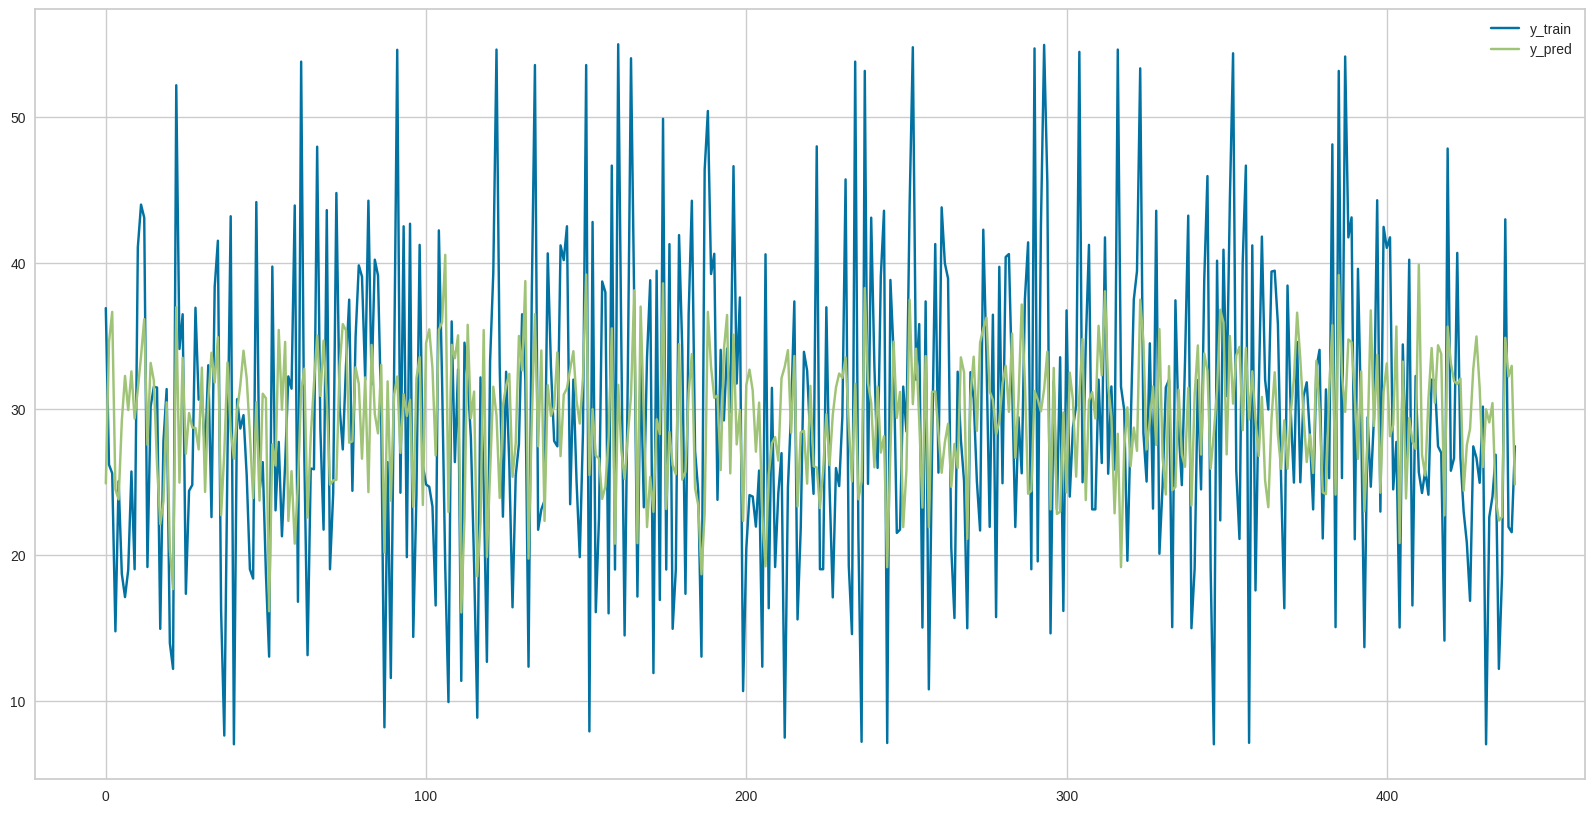

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(y_train[::10], label="y_train")
plt.plot(y_pred[::10], label="y_pred")
plt.legend()

Pela figura fica ainda mais evidente que as predições não foram boas.

Agora repita a predição e plote o gráfico para os dados de teste.

In [31]:
y_pred = lr.predict(X_test)
y_pred

array([27.89827172, 34.51070185, 25.77462058, ..., 28.09798219,
       22.04628419, 34.30987488])

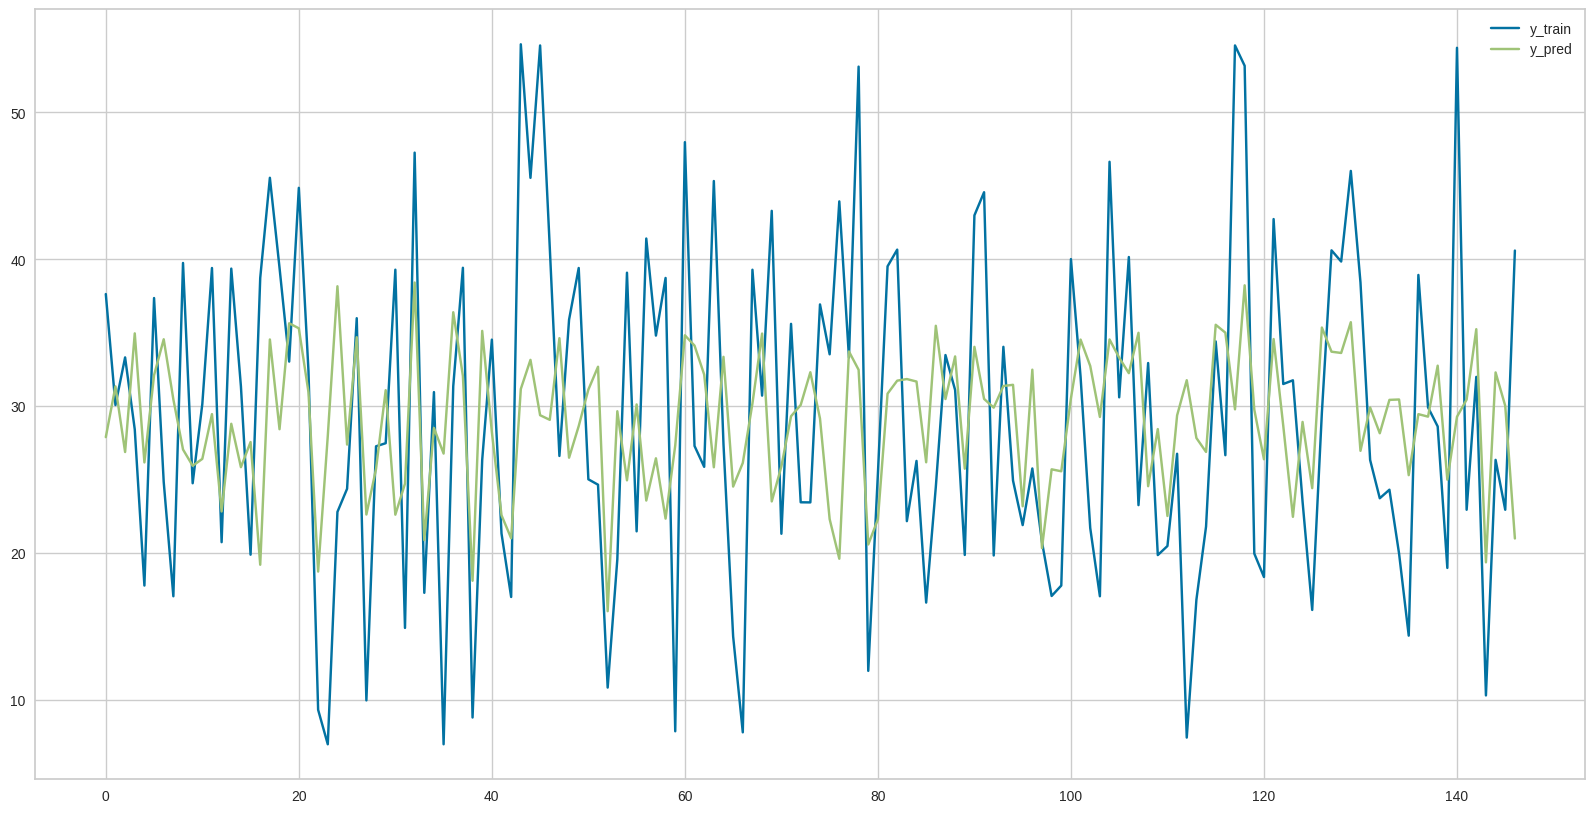

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(y_test[::10], label="y_train")
plt.plot(y_pred[::10], label="y_pred")
plt.legend()

Calcule o erro absoluto médio dos dados de teste, primeiro com a função do `sklearn`, depois utilizando cálculos básicos.

In [33]:
mean_absolute_error(y_test, y_pred)

7.9972181393275665

In [34]:
abs(y_test - y_pred).mean()

np.float64(7.9972181393275665)

Agora calcule o erro quadrado médio, e depois tire a raiz deste valor, para exibir o resultado na mesma escala de `y`.

In [35]:
mean_squared_error(y_test, y_pred)

93.93568946261169

In [36]:
np.sqrt(mean_squared_error(y_test, y_pred))

np.float64(9.69204258464704)

Exiba um gráfico com os resíduos deste modelo.

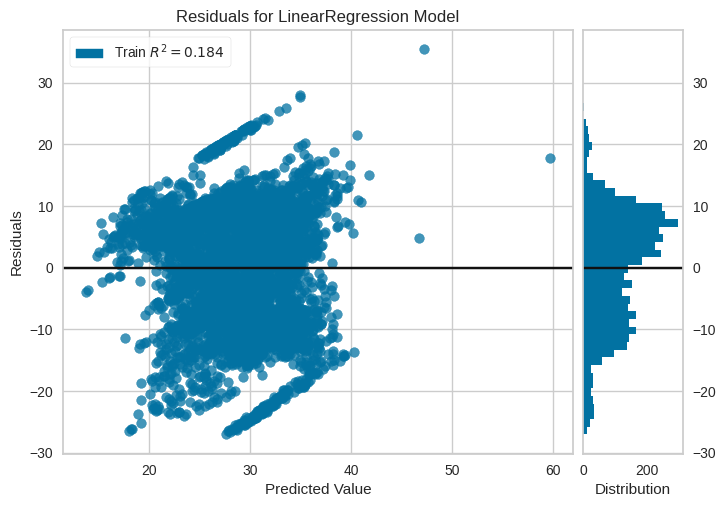

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [37]:
visualizer = ResidualsPlot(lr)
visualizer.fit(X_train, y_train)
visualizer.poof()

Realmente este regressor não se saiu nada bem.